In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from coffea import util

In [10]:
from pltStyle import pltStyle
pltStyle(style='paper')
plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

In [11]:
### Some recent file to get out the binning
outname = 'out/CoffeaJERCOutputs_L5_fine_etaBins_QCD.coffea'
output = util.load(outname)

In [12]:
f_xvals = np.linspace(0,5,5001)

ptbins = output['ptresponse'].axis('pt').edges()
ptbins_c = output['ptresponse'].axis('pt').centers()
etabins = np.array([-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5])
    

# jetpt_length = len(ptbins)-1
# jeteta_length = (len(etabins)-1)//2

etabins_mod = etabins[(len(etabins)-1)//2:]
etabins_c = (etabins_mod[:-1]+etabins_mod[1:])/2 #output['ptresponse'].axis('jeteta').centers()

In [13]:
def read_data(name, samp, tag_full):
    df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

In [14]:
def make_comparison_plot(yvar1, std1, yvar2, std2, k, samp, name1:str, name2:str):
    ''' Make a coparison and a ratio plot of yvar2 vs yvar1
    '''
    
    mean_p_QCD = yvar1.copy()
    mean_p_QCD[(mean_p_QCD==0) | (np.abs(mean_p_QCD)==np.inf)] = np.nan
    
    mean_p_TTBAR = yvar2.copy()
    mean_p_TTBAR[(mean_p_TTBAR==0) | (np.abs(mean_p_TTBAR)==np.inf)] = np.nan
    
    fig = plt.figure()
    gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
    ax = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    start = np.where(ptbins<=20)[0][-1]

    for axis in [ax.xaxis, ax.yaxis, ax2.xaxis, ax2.yaxis]:
        axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    xvals = (ptbins[start:-1] + ptbins[start+1:])/2
    wd = np.abs(ptbins[start:-1] - ptbins[start+1:])
    QCD_vals = mean_p_QCD[start:,k]
    TTbar_vals = mean_p_TTBAR[start:,k]
    
    ### Replacing response values to corrections
#     TTbar_vals = 1/TTbar_vals
#     QCD_vals = 1/QCD_vals
    
    std1 = std1[start:,k]
    std2 = std2[start:,k]
    
    ### Error propagation
#     std1 = QCD_vals**2*std1
#     std2 = TTbar_vals**2*std2
    
#     print(xvals)
#     print(QCD_vals)
#     print(std1)
    p1 = ax.errorbar(xvals, QCD_vals, yerr=std1, marker='o',
#                      markerfacecolor='none', markeredgewidth=1,
                 linestyle="none", label=name1)

    p5 = ax.errorbar(xvals, TTbar_vals, yerr=std2, marker='v',
#                      markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
                 linestyle="none", label=name2)

    ax2.hlines(1,1, 10000, linestyles='--',color="black",
        linewidth=1,)
    rel_mc_unc =  std1/QCD_vals 

    ax2.bar(
        xvals,
        2 * rel_mc_unc,
        width=wd,
        bottom=1.0 - rel_mc_unc,
        fill=False,
        linewidth=0,
        edgecolor="gray",
        hatch=10 * "/",
    )


    # data in ratio plot
    data_model_ratio = TTbar_vals/QCD_vals
    data_model_ratio_unc = std2 / QCD_vals
    # mask data in bins where total model yield is 0
    ax2.errorbar(
        xvals,
        data_model_ratio, #[nonzero_model_yield],
        yerr=data_model_ratio_unc, #[nonzero_model_yield],
        fmt="o",
        color="k",
    )


    ax2.set_ylabel(name2+" /\n "+name1)
    ax2.tick_params(axis="both", which="major", pad=8)
    ax2.tick_params(direction="in", top=True, right=True, which="both")

    fig.set_tight_layout(True)

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([std1, std2 ])
    y_norm = np.concatenate([QCD_vals, TTbar_vals])
    norm_pos = (yerr_norm<0.04) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

    yerr_norm = np.concatenate([std1/QCD_vals, std2/QCD_vals ])
    y_norm = np.concatenate([QCD_vals/QCD_vals, TTbar_vals/QCD_vals])
    norm_pos = (yerr_norm<0.03) &  (yerr_norm != np.inf) & (y_norm>-0.1) 
    left_lim = np.min((y_norm-yerr_norm)[norm_pos])
    right_lim = np.max((yerr_norm+y_norm)[norm_pos])
    lim_pad = (right_lim - left_lim)/10
    ax2.set_ylim(left_lim-lim_pad, right_lim+lim_pad)

    ax2.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'median response'); # ax.set_ylabel(r'Correction');
    ax.set_xscale('log')
    ax2.set_xscale('log')

    ax.set_xticks([])
    ax2.set_xticks([20, 50, 100, 500, 1000, 5000])
    ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    leg1 = ax.legend()

    ax2.set_xlim(ax.get_xlim())
    eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
    eta_string = eta_string.replace('.','')
    print("Saving plot for eta = ", eta_string)
    fig_name = 'fig/corr_vs_pt'+samp+eta_string+'_L5_'+name1+'-'+name2+'-median'
    fig_name = fig_name.replace(', ', '-')
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
    plt.show();

Fitting subsample:  _b
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_b_eta00to13_L5_b-bbar-median


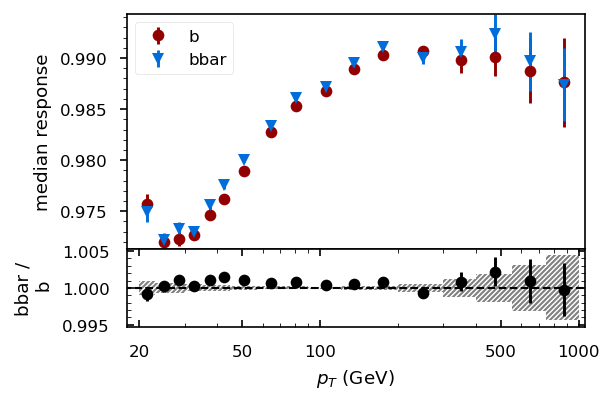

Fitting subsample:  _b
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_b_eta13to25_L5_b-bbar-median


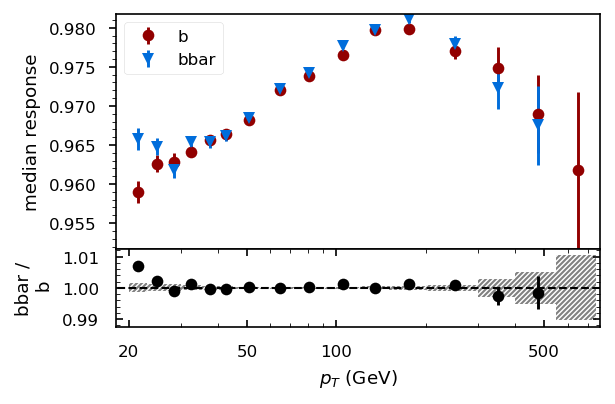

Fitting subsample:  _b
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_b_eta25to30_L5_b-bbar-median


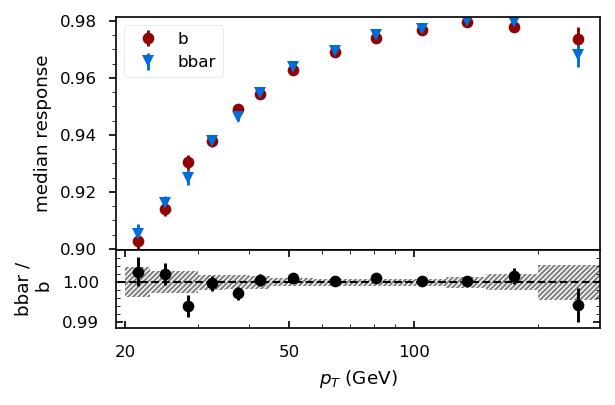

Fitting subsample:  _b
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_b_eta30to50_L5_b-bbar-median


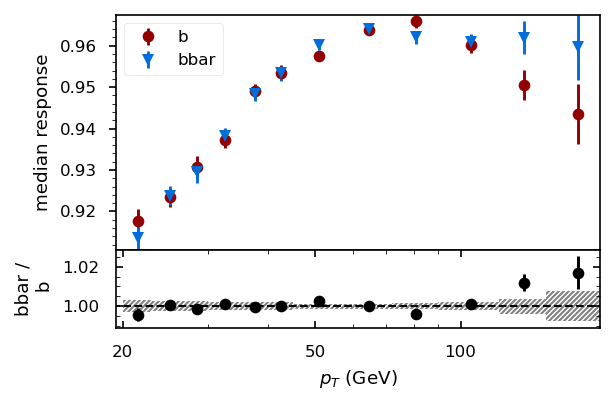

Fitting subsample:  _c
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_c_eta00to13_L5_c-cbar-median


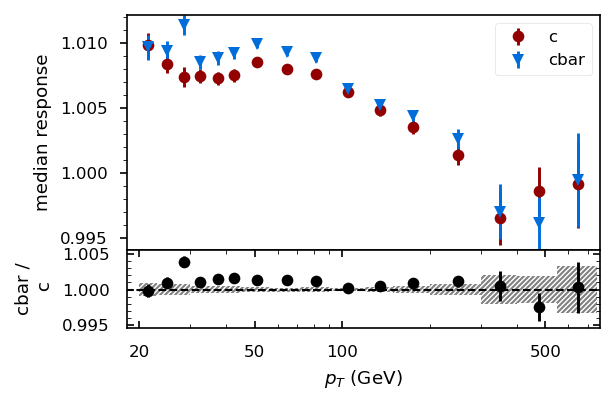

Fitting subsample:  _c
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_c_eta13to25_L5_c-cbar-median


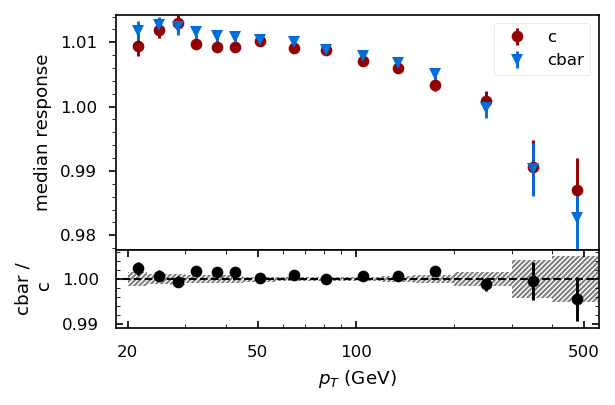

Fitting subsample:  _c
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_c_eta25to30_L5_c-cbar-median


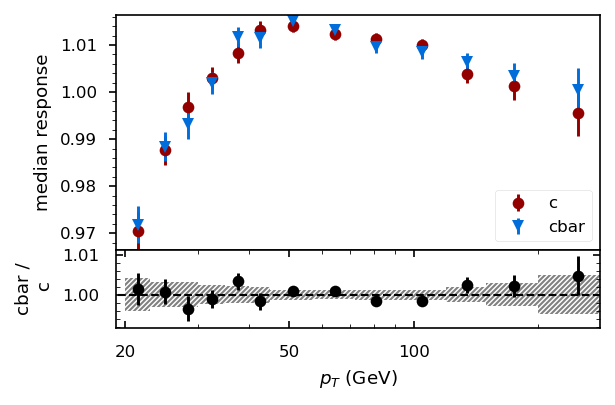

Fitting subsample:  _c
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_c_eta30to50_L5_c-cbar-median


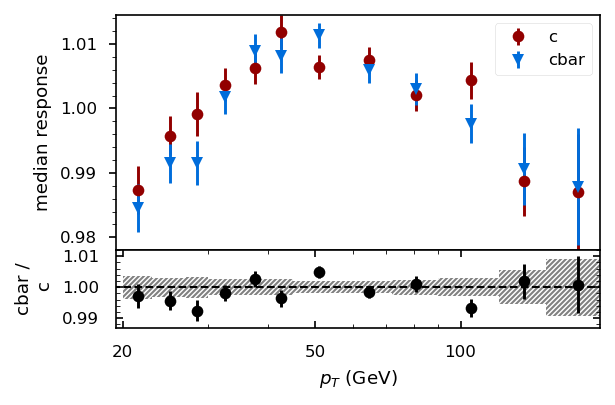

Fitting subsample:  _ud
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_ud_eta00to13_L5_ud-udbar-median


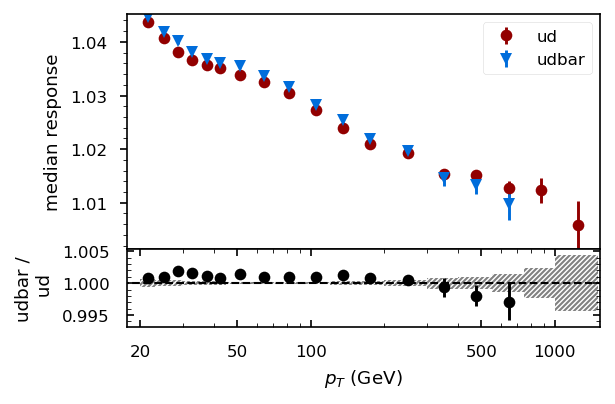

Fitting subsample:  _ud
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_ud_eta13to25_L5_ud-udbar-median


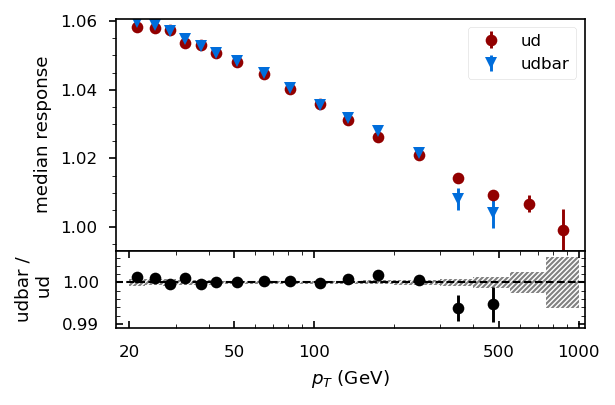

Fitting subsample:  _ud
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_ud_eta25to30_L5_ud-udbar-median


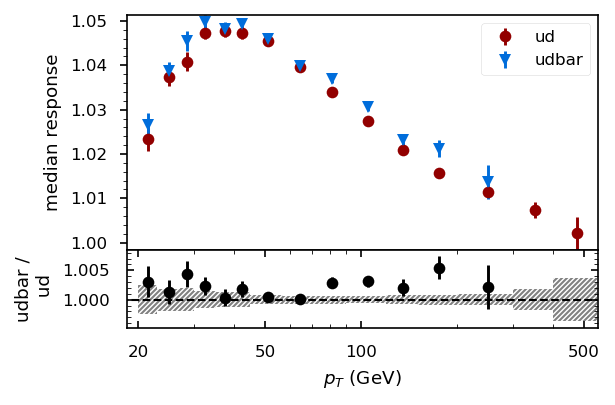

Fitting subsample:  _ud
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_ud_eta30to50_L5_ud-udbar-median


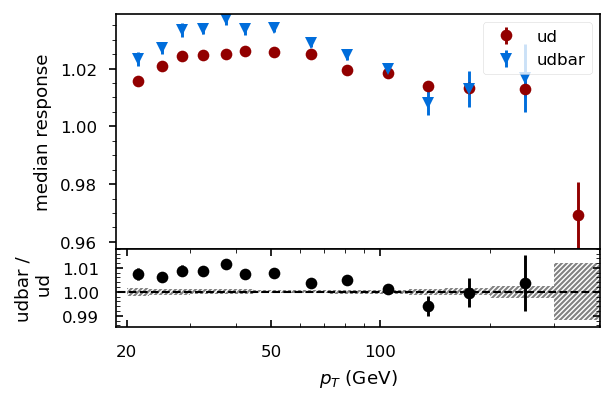

Fitting subsample:  _s
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_s_eta00to13_L5_s-sbar-median


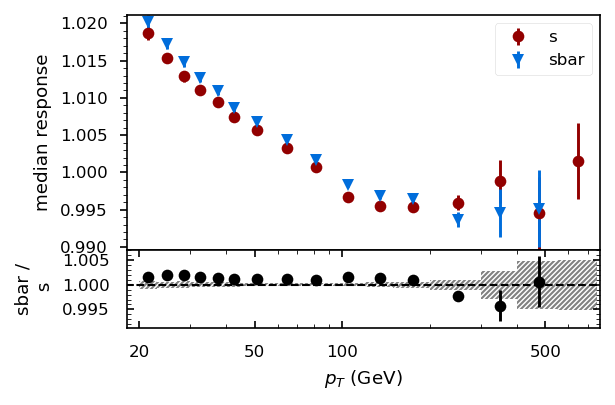

Fitting subsample:  _s
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_s_eta13to25_L5_s-sbar-median


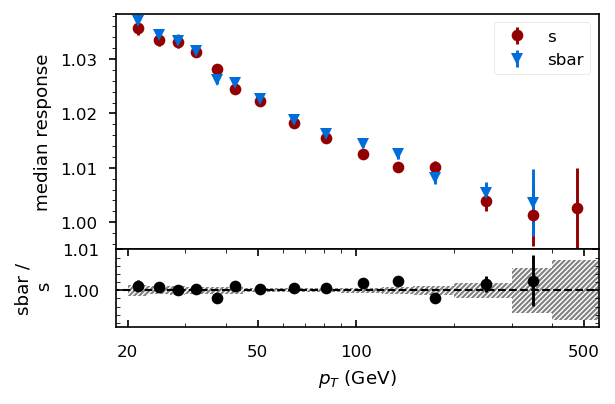

Fitting subsample:  _s
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_s_eta25to30_L5_s-sbar-median


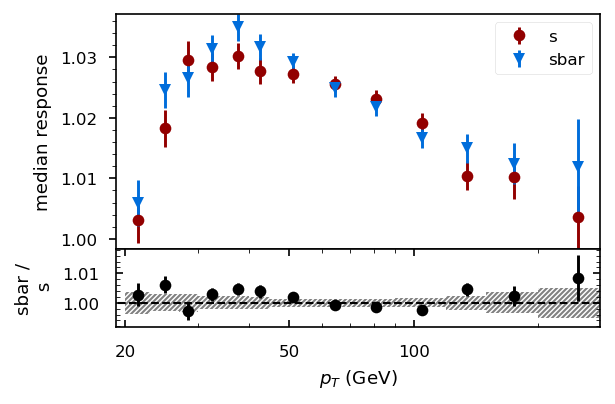

Fitting subsample:  _s
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_s_eta30to50_L5_s-sbar-median


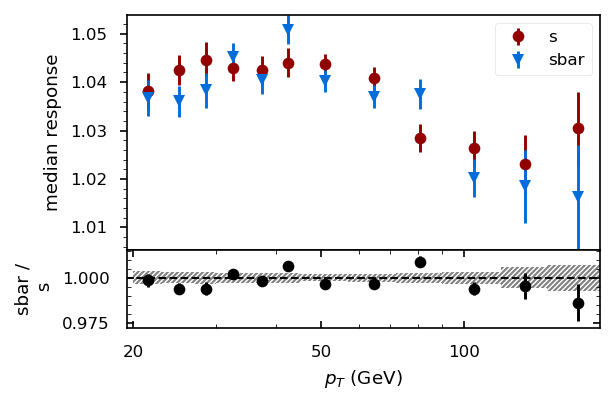

In [15]:
# load_fit_res=True
subsamples = ['_b', '_c', '_ud', '_s', '_g', '_bbar', '_cbar', '_udbar', '_sbar']
subsamples = ['_b', '_c', '_ud', '_s']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]
# ks = [k2]

# ks = [k2, k4] #, k6, k8]
# subsamples = [''] #, '_b']
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        print('Eta: ', k)
        median_QCD = read_data("Median", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
        medianstd_QCD = read_data("MedianStd", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
        median_TTBAR = read_data("Median", samp+'bar', '_L5_LHEflav1_Herwig-TTBAR-JME')
        medianstd_TTBAR = read_data("MedianStd", samp+'bar', '_L5_LHEflav1_Herwig-TTBAR-JME')
        
        
        make_comparison_plot(median_QCD, medianstd_QCD, median_TTBAR, medianstd_TTBAR,
                             k, samp, samp[1:], samp[1:]+'bar')
        
3;

In [10]:
# # load_fit_res=True
# subsamples = ['', '_b', '_c', '_s', '_ud', '_g']

# k2 = np.where(etabins_mod<=0)[0][-1]
# k4 = np.where(etabins_mod<=1.3)[0][-1]
# k6 = np.where(etabins_mod<=2.5)[0][-1]
# k8 = np.where(etabins_mod<=3.0)[0][-1]
# ks = [k2, k4, k6, k8]

# # ks = [k2, k4] #, k6, k8]
# # subsamples = [''] #, '_b']
# for samp in subsamples:
#     for k in ks:
#         print('Fitting subsample: ', samp)
#         print('Eta: ', k)
#         median_QCD = read_data("Median", samp, '_L5_LHEflav_TTBAR-JME')
#         medianstd_QCD = read_data("MedianStd", samp, '_L5_LHEflav_TTBAR-JME')
#         median_TTBAR = read_data("Median", samp, '_L5_LHEflav1_TTBAR-JME')
#         medianstd_TTBAR = read_data("MedianStd", samp, '_L5_LHEflav1_TTBAR-JME')
        
        
#         make_comparison_plot(median_QCD, medianstd_QCD, median_TTBAR, medianstd_TTBAR,
#                              k, samp, 'TTBAR, LHEflav2', 'TTBAR, LHEflav1')
        
# 3;

In [56]:
# def make_comparison_plot_three(yvar1, std1, yvar2, std2, yvar3, std3, k, samp,
#                                name1:str, name2:str, name3:str, ratio_name:str):
#     ''' Make a coparison and a ratio plot of yvar2 vs yvar1
#     '''
    
#     mean_p_base = yvar1.copy()
#     mean_p_base[(mean_p_base==0) | (np.abs(mean_p_base)==np.inf)] = np.nan
    
#     mean_p_2 = yvar2.copy()
#     mean_p_2[(mean_p_2==0) | (np.abs(mean_p_2)==np.inf)] = np.nan
    
#     mean_p_3 = yvar3.copy()
#     mean_p_3[(mean_p_3==0) | (np.abs(mean_p_3)==np.inf)] = np.nan

#     fig = plt.figure()
#     gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
#     ax = fig.add_subplot(gs[0])
#     ax2 = fig.add_subplot(gs[1])
#     start = np.where(ptbins<=20)[0][-1]

#     for axis in [ax.xaxis, ax.yaxis, ax2.xaxis, ax2.yaxis]:
#         axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

#     xvals = (ptbins[start:-1] + ptbins[start+1:])/2
#     wd = np.abs(ptbins[start:-1] - ptbins[start+1:])
#     vals_base = mean_p_base[start:,k]
#     vals_2 = mean_p_2[start:,k]
#     vals_3 = mean_p_3[start:,k]

# #     print(xvals)
# #     print(vals_base)
#     p1 = ax.errorbar(xvals, vals_base, yerr=std1[start:,k], marker='o',
# #                      markerfacecolor='none', markeredgewidth=1,
#                  linestyle="none", label=name1, color='k')

#     p5 = ax.errorbar(xvals, vals_2, yerr=std2[start:,k], marker='v',
# #                      markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
#                  linestyle="none", label=name2)
    
#     p5 = ax.errorbar(xvals, vals_3, yerr=std3[start:,k], marker='^',
# #                      markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
#                  linestyle="none", label=name3)

#     ax2.hlines(1,1, 10000, linestyles='--',color="black",
#         linewidth=1,)
#     rel_mc_unc =  std1[start:,k]/vals_base 

#     ax2.bar(
#         xvals,
#         2 * rel_mc_unc,
#         width=wd,
#         bottom=1.0 - rel_mc_unc,
#         fill=False,
#         linewidth=0,
#         edgecolor="gray",
#         hatch=10 * "/",
#     )


#     # data in ratio plot
#     data_model_ratio = vals_2/vals_base
#     data_model_ratio_unc = std2[start:,k] / vals_base
# #     print(vals_2)
# #     print(vals_base)
# #     print(data_model_ratio)
#     # mask data in bins where total model yield is 0
#     ax2.errorbar(
#         xvals,
#         data_model_ratio, #[nonzero_model_yield],
#         yerr=data_model_ratio_unc, #[nonzero_model_yield],
#         fmt="v",
# #         color="k",
#     )
    
#     # data in ratio plot 2
#     data_model_ratio_2 = vals_3/vals_base
#     data_model_ratio_unc_2 = std3[start:,k] / vals_base
#     # mask data in bins where total model yield is 0
#     ax2.errorbar(
#         xvals,
#         data_model_ratio_2, #[nonzero_model_yield],
#         yerr=data_model_ratio_unc_2, #[nonzero_model_yield],
#         fmt="^",
# #         color="k",
#     )


#     ax2.set_ylabel(ratio_name)
#     ax2.tick_params(axis="both", which="major", pad=8)
#     ax2.tick_params(direction="in", top=True, right=True, which="both")

#     fig.set_tight_layout(True)

#     ### Calculate resonable limits excluding the few points with insane errors
#     yerr_norm = np.concatenate([std1[start:,k], std2[start:,k], std3[start:,k] ])
#     y_norm = np.concatenate([vals_base, vals_2, vals_3])
#     norm_pos = (yerr_norm<0.04) &  (yerr_norm != np.inf) & (y_norm>-0.1)
#     ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

#     yerr_norm = np.concatenate([std1[start:,k]/vals_base, std2[start:,k]/vals_base, std3[start:,k]/vals_base ])
#     y_norm = np.concatenate([vals_base/vals_base, data_model_ratio, data_model_ratio_2])
#     norm_pos = (yerr_norm<0.008) &  (yerr_norm != np.inf) & (y_norm>-0.1)  
# #     if samp == '_b' and k==3:
# #         1/0
#     left_lim = np.min((y_norm-yerr_norm)[norm_pos])
#     right_lim = np.max((yerr_norm+y_norm)[norm_pos])
#     lim_pad = (right_lim - left_lim)/10
#     ax2.set_ylim(left_lim-lim_pad, right_lim+lim_pad)

#     ax2.set_xlabel(r'$p_T$ (GeV)');
#     ax.set_ylabel(r'median response');
#     ax.set_xscale('log')
#     ax2.set_xscale('log')

#     ax.set_xticks([])
#     ax2.set_xticks([20, 50, 100, 500, 1000, 5000])
#     ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#     leg1 = ax.legend()

#     ax2.set_xlim(ax.get_xlim())
#     eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
#     eta_string = eta_string.replace('.','')
#     print("Saving plot for eta = ", eta_string)
#     fig_name = 'fig/corr_vs_pt'+samp+eta_string+'_L5_'+name1+'-'+name2+'-'+name3+'-median'
#     fig_name = fig_name.replace(', ', '-')
#     print("Saving plot with the name = ", fig_name)
#     plt.savefig(fig_name+'.pdf');
#     plt.savefig(fig_name+'.png');
#     # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
#     plt.show();

In [69]:
def make_comparison_plot_many(yvar_base, std_base, yvars = np.array([]), stds = np.array([]), k=0, samp='',
                               name_base='', names=[], ratio_name='ratio'):
    ''' Make a coparison and a ratio plot of yvar2 vs yvar_base
    '''
    
    mean_p_base = yvar_base.copy()
    mean_p_base[(mean_p_base==0) | (np.abs(mean_p_base)==np.inf)] = np.nan
    
    # mean_ps = []
    # for yvar in yvars:
    #     mean_ps = yvar.copy()

    yvars[(yvars==0) | (np.abs(yvars)==np.inf)] = np.nan


    fig = plt.figure()
    gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
    ax = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    start = np.where(ptbins<=20)[0][-1]

    for axis in [ax.xaxis, ax.yaxis, ax2.xaxis, ax2.yaxis]:
        axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    xvals = (ptbins[start:-1] + ptbins[start+1:])/2
    wd = np.abs(ptbins[start:-1] - ptbins[start+1:])
    vals_base = mean_p_base[start:,k]
    yvars = yvars[:,start:,k]
    std_base = std_base[start:,k]
    stds = stds[:,start:,k]

#     print(xvals)
#     print(vals_base)
    p1 = ax.errorbar(xvals, vals_base, yerr=std_base, marker='o',
#                      markerfacecolor='none', markeredgewidth=1,
                 linestyle="none", label=name_base, color='k')

    markers = ['v','^','d', 'p']
    for val, name, std, marker in zip(yvars, names, stds, markers):
        ax.errorbar(xvals, val, yerr=std, marker=marker,
                    linestyle="none", label=name)
        
    ax2.hlines(1,1, 10000, linestyles='--',color="black",
        linewidth=1,)
    rel_mc_unc =  std_base/vals_base 

    ax2.bar(
        xvals,
        2 * rel_mc_unc,
        width=wd,
        bottom=1.0 - rel_mc_unc,
        fill=False,
        linewidth=0,
        edgecolor="gray",
        hatch=10 * "/",
    )


    # data in ratio plot
    data_model_ratio = yvars/vals_base
    data_model_ratio_unc = stds / vals_base

    for val, std, marker in zip(data_model_ratio, data_model_ratio_unc, markers):
        ax2.errorbar(
            xvals,
            val, #[nonzero_model_yield],
            yerr=std, #[nonzero_model_yield],
            fmt=marker,
        )
    

    ax2.set_ylabel(ratio_name)
    ax2.tick_params(axis="both", which="major", pad=8)
    ax2.tick_params(direction="in", top=True, right=True, which="both")

    fig.set_tight_layout(True)

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([std_base, np.concatenate(stds) ])
    y_norm = np.concatenate([vals_base, np.concatenate(yvars)])
    norm_pos = (yerr_norm<0.04) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

    yerr_norm = np.concatenate([rel_mc_unc, np.concatenate(data_model_ratio_unc) ])
    y_norm = np.concatenate([vals_base/vals_base, np.concatenate(data_model_ratio)])
    norm_pos = (yerr_norm<0.008) &  (yerr_norm != np.inf) & (y_norm>-0.1)  
#     if samp == '_b' and k==3:
#         1/0
    left_lim = np.min((y_norm-yerr_norm)[norm_pos])
    right_lim = np.max((yerr_norm+y_norm)[norm_pos])
    lim_pad = (right_lim - left_lim)/10
    ax2.set_ylim(left_lim-lim_pad, right_lim+lim_pad)

    ax2.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'median response');
    ax.set_xscale('log')
    ax2.set_xscale('log')

    ax.set_xticks([])
    ax2.set_xticks([20, 50, 100, 500, 1000, 5000])
    ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    leg1 = ax.legend()

    ax2.set_xlim(ax.get_xlim())
    eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
    eta_string = eta_string.replace('.','')
    print("Saving plot for eta = ", eta_string)
    fig_name = 'fig/corr_vs_pt'+samp+eta_string+'_L5_'+name_base+'-'+'-'.join(names)+'-median'
    fig_name = fig_name.replace(', ', '-')
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
    plt.show();

Fitting subsample:  
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


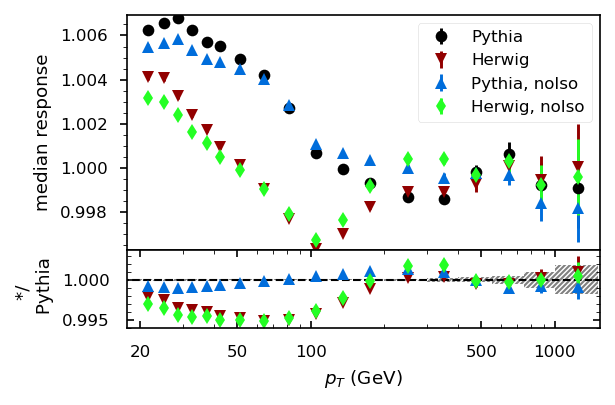

Fitting subsample:  
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


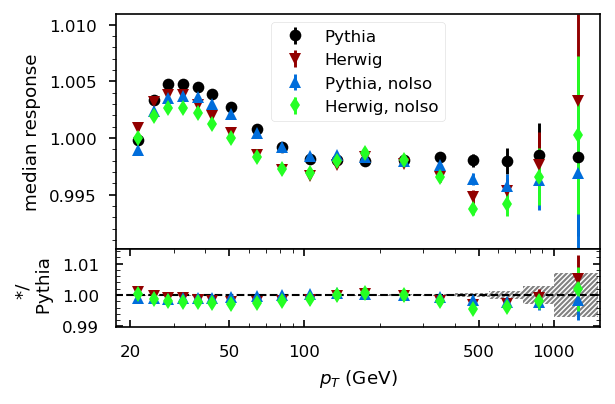

Fitting subsample:  
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


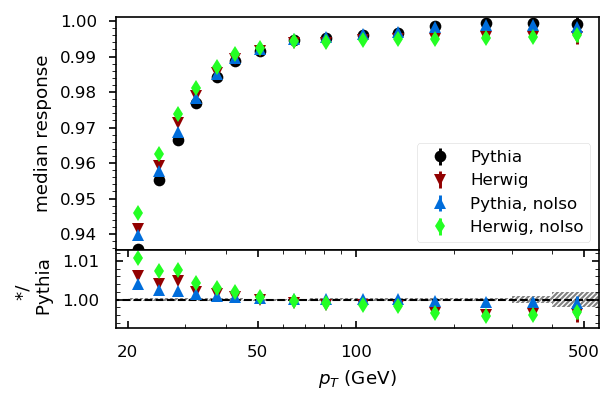

Fitting subsample:  
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


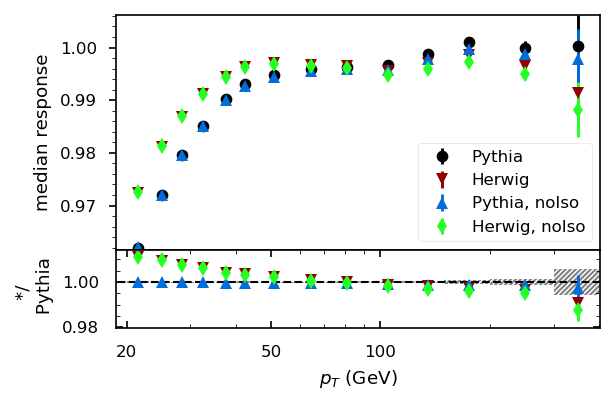

Fitting subsample:  _b
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_b_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


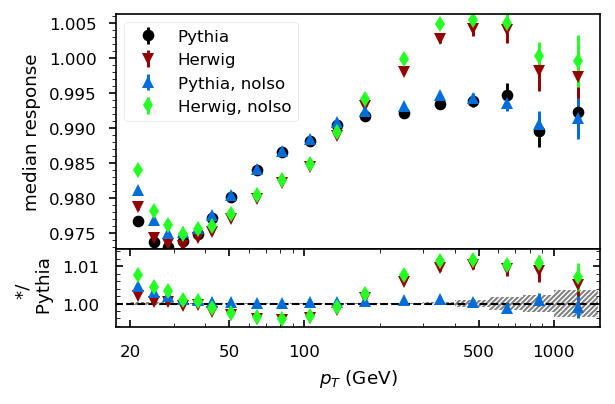

Fitting subsample:  _b
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_b_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


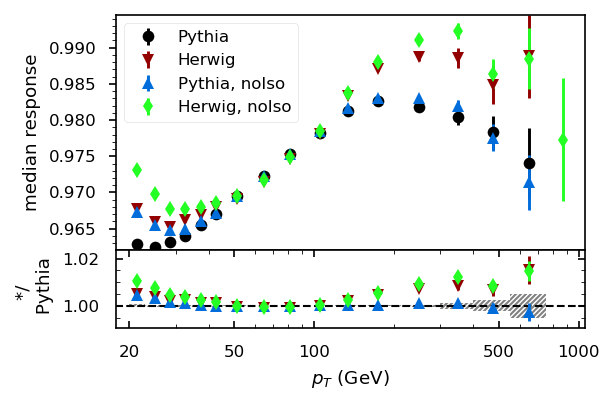

Fitting subsample:  _b
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_b_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


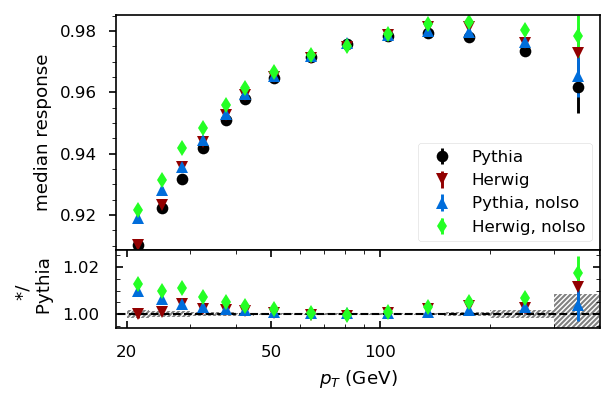

Fitting subsample:  _b
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_b_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


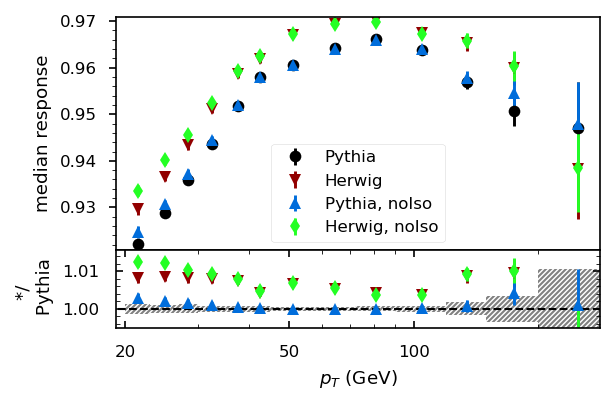

Fitting subsample:  _c
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_c_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


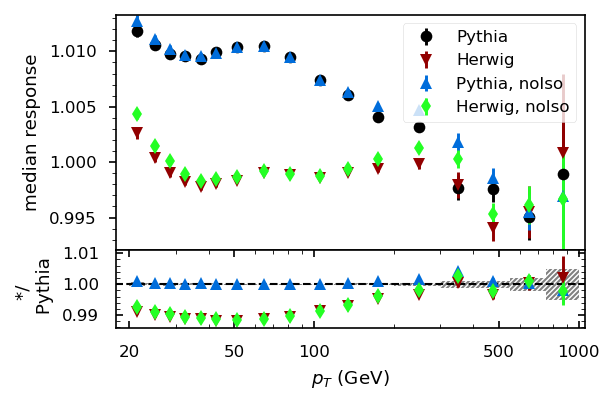

Fitting subsample:  _c
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_c_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


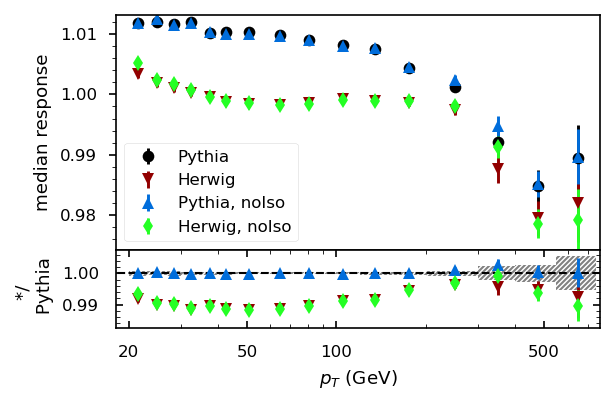

Fitting subsample:  _c
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_c_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


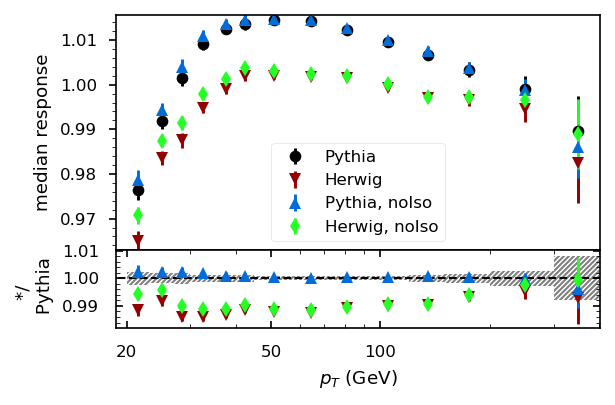

Fitting subsample:  _c
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_c_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


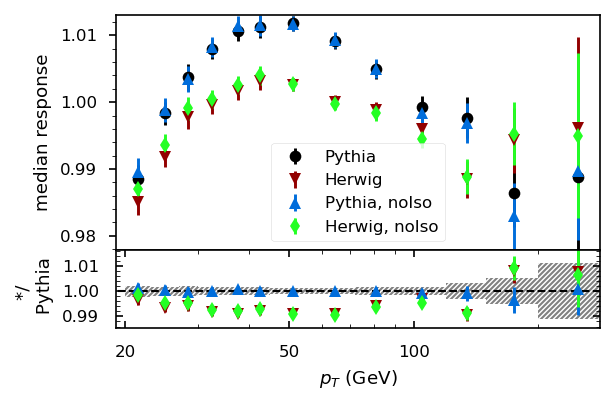

Fitting subsample:  _s
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_s_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


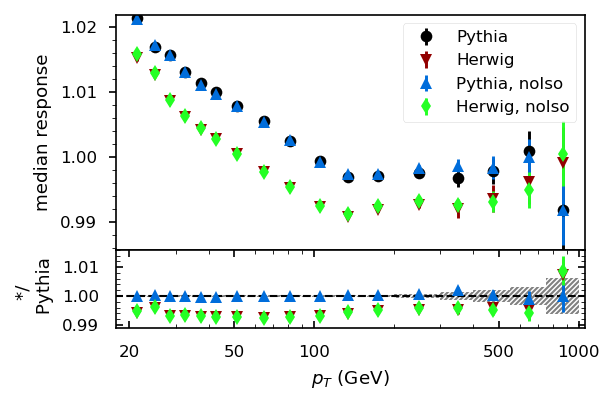

Fitting subsample:  _s
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_s_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


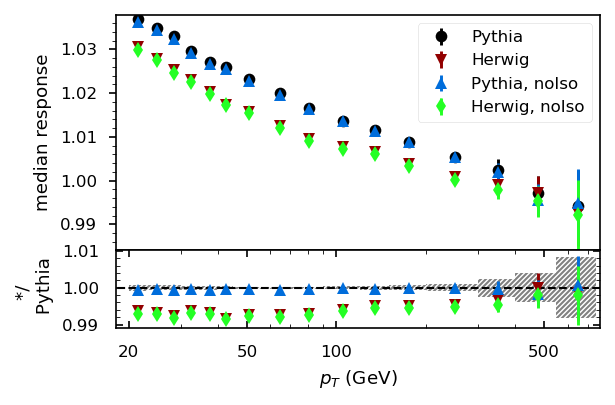

Fitting subsample:  _s
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_s_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


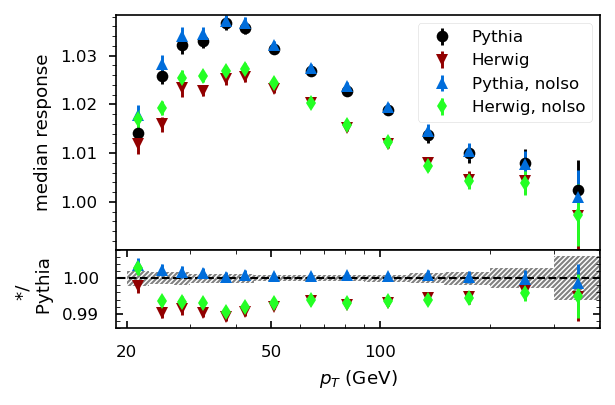

Fitting subsample:  _s
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_s_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


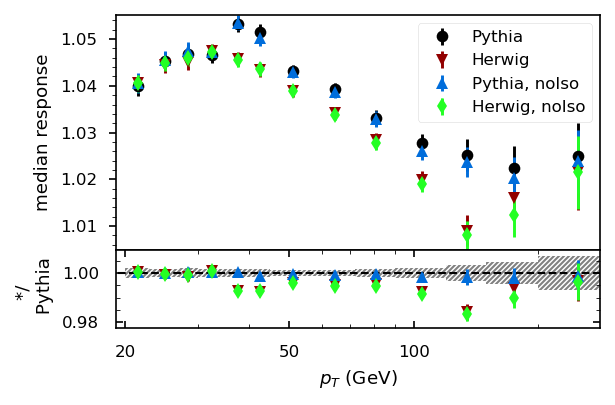

Fitting subsample:  _ud
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_ud_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


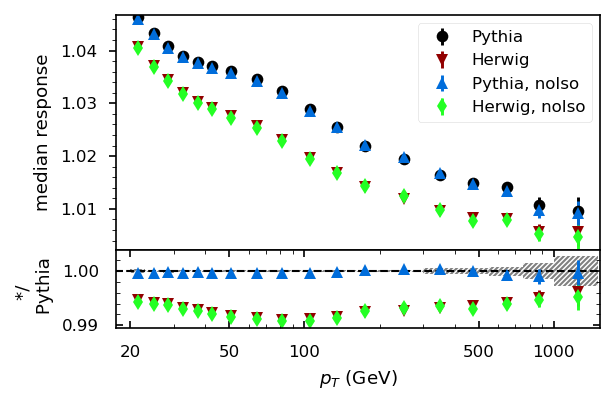

Fitting subsample:  _ud
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_ud_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


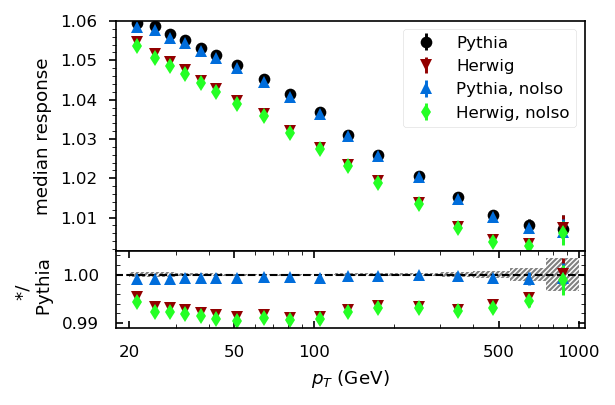

Fitting subsample:  _ud
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_ud_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


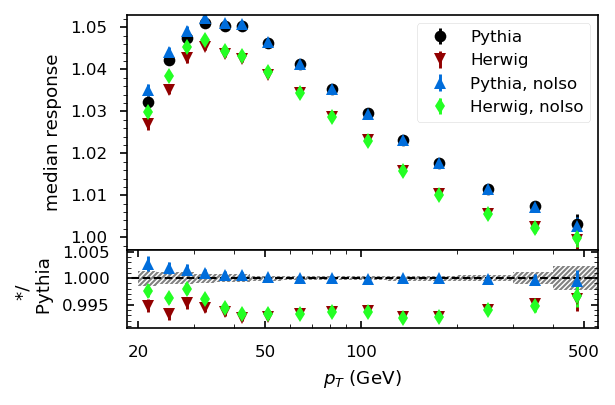

Fitting subsample:  _ud
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_ud_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


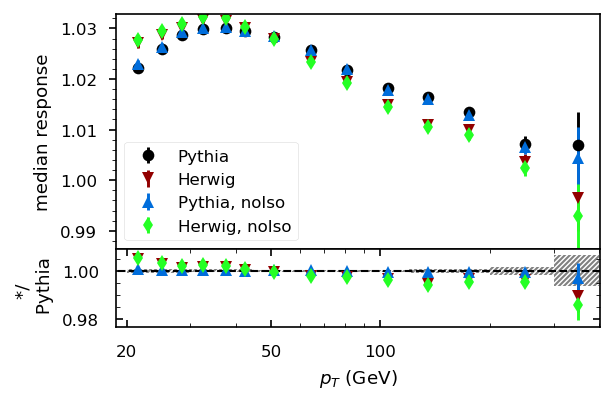

Fitting subsample:  _g
Eta:  0
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_g_eta00to13_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


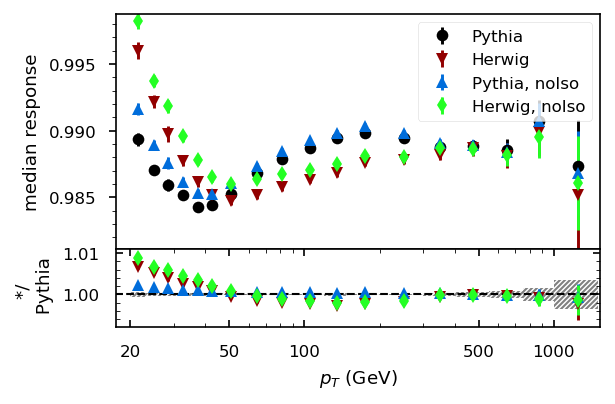

Fitting subsample:  _g
Eta:  1
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_g_eta13to25_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


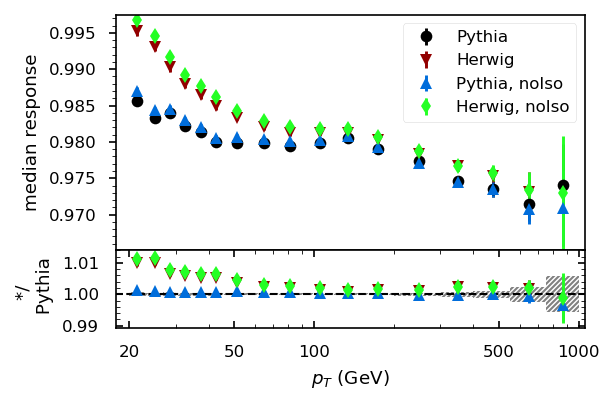

Fitting subsample:  _g
Eta:  2
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_g_eta25to30_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


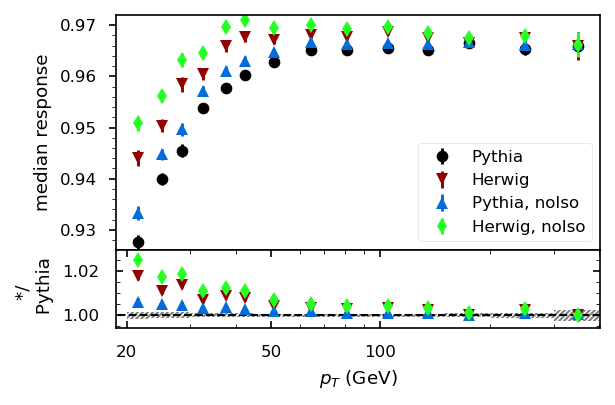

Fitting subsample:  _g
Eta:  3
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_g_eta30to50_L5_Pythia-Herwig-Pythia-noIso-Herwig-noIso-median


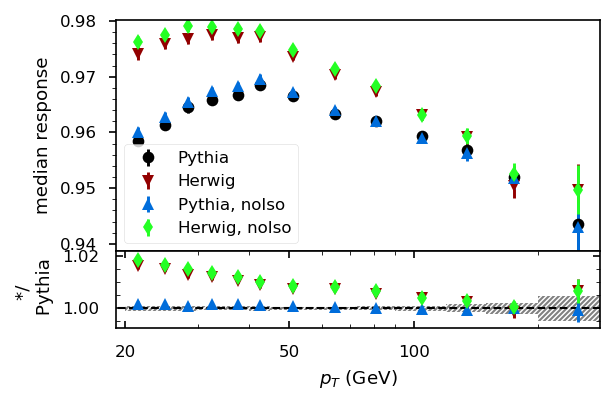

In [73]:
# load_fit_res=True
subsamples = ['', '_b', '_c', '_s', '_ud', '_g']
# subsamples = ['_g']


k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

# ks = [k2, k4] #, k6, k8]
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        print('Eta: ', k)
        median_QCD = read_data("Median", samp, '_L5_LHEflav1_TTBAR-JME')
        medianstd_QCD = read_data("MedianStd", samp, '_L5_LHEflav1_TTBAR-JME')
        median_TTBAR = read_data("Median", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
        medianstd_TTBAR = read_data("MedianStd", samp, '_L5_LHEflav1_Herwig-TTBAR-JME')
        median_3 = read_data("Median", samp, '_L5_LHEflav1_TTBAR-JME-noIso')
        medianstd_3 = read_data("MedianStd", samp, '_L5_LHEflav1_TTBAR-JME-noIso')
        median_4 = read_data("Median", samp, '_L5_LHEflav1_Herwig-TTBAR-JME-noIso')
        medianstd_4 = read_data("MedianStd", samp, '_L5_LHEflav1_Herwig-TTBAR-JME-noIso')
        
        
        make_comparison_plot_many(median_QCD, medianstd_QCD,
                                  np.array([median_TTBAR, median_3, median_4]),
                                  np.array([medianstd_TTBAR, medianstd_3, medianstd_4]),
                             k, samp, 'Pythia', ['Herwig', 'Pythia, noIso', 'Herwig, noIso'], '*/ \n Pythia')
        
3;

In [ ]:
# # load_fit_res=True
# subsamples = ['', '_b', '_c', '_l', '_g']

# k2 = np.where(etabins_mod<=0)[0][-1]
# k4 = np.where(etabins_mod<=1.3)[0][-1]
# k6 = np.where(etabins_mod<=2.5)[0][-1]
# k8 = np.where(etabins_mod<=3.0)[0][-1]
# ks = [k2, k4, k6, k8]

# # ks = [k2, k4] #, k6, k8]
# # subsamples = ['_b'] #, '_b']
# for samp in subsamples:
#     for k in ks:
# #     print('-'*25)
# #     print('-'*25)
#         print('Fitting subsample: ', samp)
#         mean_QCD = read_data("Mean", samp, '_L5_QCD')
#         meanvar_QCD = read_data("MeanVar", samp, '_L5_QCD')
#         mean_TTBAR = read_data("Mean", samp, '_L5_TTBAR')
#         meanvar_TTBAR = read_data("MeanVar", samp, '_L5_TTBAR')
        
        
#         mean_p_QCD = mean_QCD.copy()
#         mean_p_QCD[mean_p_QCD==0] = np.nan

#         mean_p_TTBAR = mean_TTBAR.copy()
#         mean_p_TTBAR[mean_p_TTBAR==0] = np.nan

#         fig = plt.figure()
#         gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
#         ax = fig.add_subplot(gs[0])
#         ax2 = fig.add_subplot(gs[1])
# #         fig, [ax,ax2] = plt.subplots(nrows=2, ncols=1)
#         start = 17
    
# #         for item in (
# #             [ax1.yaxis.label, ax2.xaxis.label, ax2.yaxis.label]
# #             + ax1.get_yticklabels()
# #             + ax2.get_xticklabels()
# #             + ax2.get_yticklabels()
# #         ):
# #             item.set_fontsize("large")
    
#         for axis in [ax.xaxis, ax.yaxis, ax2.xaxis, ax2.yaxis]:
#             axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

#         xvals = (ptbins[start:-1] + ptbins[start+1:])/2
#         wd = np.abs(ptbins[start:-1] - ptbins[start+1:])
#         QCD_vals = mean_p_QCD[start:,k]
#         TTbar_vals = mean_p_TTBAR[start:,k]

#         p1 = ax.errorbar(xvals, QCD_vals, yerr=np.sqrt(meanvar_QCD[start:,k]), marker='o',
# #                      markerfacecolor='none', markeredgewidth=1,
#                      linestyle="none", label='QCD')

#         p5 = ax.errorbar(xvals, TTbar_vals, yerr=np.sqrt(meanvar_TTBAR[start:,k]), marker='v',
# #                      markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
#                      linestyle="none", label='TTBAR')
        
#         ax2.hlines(1,1, 10000, linestyles='--',color="black",
#             linewidth=1,)
#         # ratio plot
# #         ax2.plot(
# #             [ptbins[0], ptbins[-1]],
# #             [1, 1],
# #             "--",
# #             color="black",
# #             linewidth=1,
# #         )  # reference line along y=1
        
# #         nonzero_model_yield = mean_p_QCD[start:,k] != 0.0
#         rel_mc_unc =  np.sqrt(meanvar_QCD[start:,k])/QCD_vals 
        
#         ax2.bar(
#             xvals,
#             2 * rel_mc_unc,
#             width=wd,
#             bottom=1.0 - rel_mc_unc,
#             fill=False,
#             linewidth=0,
#             edgecolor="gray",
#             hatch=10 * "/",
#         )
        
        
# #         ax3 = ax.twinx()
# #         ax3.plot(np.nan, marker='o',color='k',markerfacecolor='none', markeredgewidth=1, linestyle="none", label='QCD')
# #         ax3.plot(np.nan, marker='v',color='k',markerfacecolor='none', markeredgewidth=1, linestyle="none", label='TTBAR')

#         # data in ratio plot
#         data_model_ratio = TTbar_vals/QCD_vals
#         data_model_ratio_unc = np.sqrt(meanvar_TTBAR[start:,k]) / QCD_vals
#         # mask data in bins where total model yield is 0
#         ax2.errorbar(
#             xvals,
#             data_model_ratio, #[nonzero_model_yield],
#             yerr=data_model_ratio_unc, #[nonzero_model_yield],
#             fmt="o",
#             color="k",
#         )
        
# #             # figure label (region name)
# #         label = 'Blaaaaah'
# #         at = mpl.offsetbox.AnchoredText(
# #             label,
# #             loc="upper left",
# #             frameon=False,
# #             prop={"fontsize": "large", "linespacing": 1.5},
# #         )
# #         ax.add_artist(at)
        
# #         ax.set_xlim(ptbins[start],ptbins[-1])

        
#         ax2.set_ylabel("TTbar / QCD")
#         ax2.tick_params(axis="both", which="major", pad=8)
#         ax2.tick_params(direction="in", top=True, right=True, which="both")

#         fig.set_tight_layout(True)

#         ### Calculate resonable limits excluding the few points with insane errors
#         yerr_norm = np.concatenate([np.sqrt(meanvar_QCD[start:,k]), np.sqrt(meanvar_TTBAR[start:,k]) ])
#         y_norm = np.concatenate([QCD_vals, TTbar_vals])
#         norm_pos = (yerr_norm<0.03) &  (yerr_norm != np.inf) & (y_norm>-0.1)
#         ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))
        
#         yerr_norm = np.concatenate([np.sqrt(meanvar_QCD[start:,k])/QCD_vals, np.sqrt(meanvar_TTBAR[start:,k])/QCD_vals ])
#         y_norm = np.concatenate([QCD_vals/QCD_vals, TTbar_vals/QCD_vals])
#         norm_pos = (yerr_norm<0.03) &  (yerr_norm != np.inf) & (y_norm>-0.1) 
#         ax2.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

#         ax2.set_xlabel(r'$p_T$ (GeV)');
# #         ax.set_xlabel(r'$p_T$ (GeV)');
#         ax.set_ylabel(r'mean response');
#         ax.set_xscale('log')
#         ax2.set_xscale('log')
        
#         ax.set_xticks([])
#         ax2.set_xticks([20, 50,100, 500, 1000, 5000])
# #         ax.get_xaxis().get_major_formatter().labelOnlyBase = False
#         ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#         leg1 = ax.legend()
# #         leg1 = ax3.legend(loc='upper left')
#         # fig.legend((p1, p5), ('QCD', 'TTBAR'), loc='upper right')  #,bbox_to_anchor=(0.5, 0., 0.47, 0.98)) #loc="upper right")
#         # if test_run:
#         #     plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
#         #     plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
#         # else:
# #         print("x lim = ", ax.get_xlim())
#         ax2.set_xlim(ax.get_xlim())
#         eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
#         eta_string = eta_string.replace('.','')
        
#         plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_QCD_TTBAR.pdf');
#         plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_QCD_TTBAR.png');
#         # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
#         plt.show();
# 3;

### Playing with coffea, uproot

In [47]:
semilepxsec = 0.108*3*0.337*2*2
dilepxsec = 0.108*3*0.108*3
fullhadxsec = 0.337*2*0.337*2



In [48]:
fullhadxsec/semilepxsec

1.0401234567901236

In [49]:
'root://xrootd-cms.infn.it//store/mc/RunIISummer20UL18NanoAODv9/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/250000/D1276FDA-2B42-E140-8AB1-8ABFE1CEA856.root'

'root://xrootd-cms.infn.it//store/mc/RunIISummer20UL18NanoAODv9/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/250000/D1276FDA-2B42-E140-8AB1-8ABFE1CEA856.root'

In [20]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

from coffea.jetmet_tools import JetCorrectionUncertainty #FactorizedJetCorrector
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory

from coffea.lookup_tools import extractor

events = NanoEventsFactory.from_root(
#     'root://xrootd-cms.infn.it//store/mc/RunIISummer20UL18NanoAODv9/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/250000/C9EC29EC-C281-E347-BEF7-383250EFAA56.root',
#       'root://cmsxrootd.fnal.gov///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/2459AA69-40B1-A944-9E65-DAAE7AF07C5A.root',
#     'root://cmsxrootd.fnal.gov///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/0230241E-754C-954D-B5D5-C104C1550830.root',
#     'root://cmsxrootd.fnal.gov///store/mc/RunIISummer20UL18NanoAODv9/TT_TuneCH3_13TeV-powheg-herwig7/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/260000/AFB5FE74-F6F0-6D45-A94B-FABA27EA44E8.root',
    'root://cmsxrootd.fnal.gov///store/mc/RunIISummer20UL18NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/120000/87DEE912-70CF-A549-B10B-1A229B256E88.root', #fileslist[0],
#     "https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/"\
#     "TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/"\
#     "00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root",
    #     'root://cmsxrootd.fnal.gov///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/0ED70AAD-357D-6646-985A-87C201AB6CD8.root',
    schemaclass=NanoAODSchema.v6,
    entry_stop=1000,
    metadata={
#             "dataset": "TTBAR",
#               "xsec":semilepxsec,
             },
).events()
# events.keys()

In [21]:
# from coffea.processor import dict_accumulator, column_accumulator, defaultdict_accumulator
# from coffea import hist, processor

In [22]:
# bla = processor.defaultdict_accumulator(dict)
# bla['cutflow']

In [23]:
# apply npv cuts
npvCut = (events.PV.npvsGood > 0)
pvzCut = (np.abs(events.PV.z) < 24)
rxyCut = (np.sqrt(events.PV.x*events.PV.x + events.PV.y*events.PV.y) < 2)

selectedEvents = events[npvCut & pvzCut & rxyCut]

In [24]:
dressedLepCut = events.GenDressedLepton

In [27]:
jets = selectedEvents.Jet
ext = extractor()
ext.add_weight_sets([
    "* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L1FastJet_AK4PFchs.txt",
    "* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L2Relative_AK4PFchs.txt",
    "* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L3Absolute_AK4PFchs.txt",
    "* * Winter14_V8_MC_L5Flavor_AK5Calo.txt",
#     "* * Summer20UL18_V2_MC/Summer20UL18_V5_MC_L2L3Residual_AK4PFchs.txt", #Doesn't do anything but for transparancy I add it
])
ext.finalize()

jec_stack_names = ["Summer20UL18_V2_MC_L1FastJet_AK4PFchs",
                   "Summer20UL18_V2_MC_L2Relative_AK4PFchs", 
                   "Summer20UL18_V2_MC_L3Absolute_AK4PFchs",
                   "Winter14_V8_MC_L5Flavor_AK5Calo.txt",
#                    "Summer20UL18_V5_MC_L2L3Residual_AK4PFchs",
                  ]

evaluator = ext.make_evaluator()

print(evaluator)
print(evaluator.keys())

jec_inputs = {name: evaluator[name] for name in jec_stack_names}
jec_stack = JECStack(jec_inputs)

ValueError: Some errors were detected !
    Line #9 (got 1 columns instead of 11)
    Line #10 (got 7 columns instead of 11)
    Line #19 (got 1 columns instead of 11)
    Line #20 (got 7 columns instead of 11)
    Line #29 (got 1 columns instead of 11)
    Line #30 (got 7 columns instead of 11)
    Line #39 (got 1 columns instead of 11)
    Line #40 (got 7 columns instead of 11)
    Line #49 (got 1 columns instead of 11)
    Line #50 (got 7 columns instead of 11)
    Line #59 (got 1 columns instead of 11)
    Line #60 (got 7 columns instead of 11)
    Line #69 (got 1 columns instead of 11)
    Line #70 (got 7 columns instead of 11)

In [208]:
name_map = jec_stack.blank_name_map
name_map['JetPt'] = 'pt'
name_map['JetMass'] = 'mass'
name_map['JetEta'] = 'eta'
name_map['JetA'] = 'area'
name_map['ptGenJet'] = 'pt_gen'
name_map['ptRaw'] = 'pt_raw'
name_map['massRaw'] = 'mass_raw'
name_map['Rho'] = 'rho'
        
events_cache = events.caches[0]
jet_factory = CorrectedJetsFactory(name_map, jec_stack)
# corrected_jets = jet_factory.build(jets, lazy_cache=events_cache)

In [209]:
jets['pt_raw'] = (1 - jets['rawFactor']) * jets['pt']
jets['mass_raw'] = (1 - jets['rawFactor']) * jets['mass']
jets['pt_gen'] = ak.values_astype(ak.fill_none(jets.matched_gen.pt, 0), np.float32)
jets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll[:10], jets['pt'])[0]

In [210]:
# LHE_flavour = ak.zeros_like(jets.hadronFlavour)
# LHE_flavour_np = ak.flatten(LHE_flavour).to_numpy().copy()

LHE_flavour_2 = ak.zeros_like(jets.hadronFlavour)
jet_shape2 = ak.num(jets.hadronFlavour)

LHE_flavour_np_2 = ak.flatten(LHE_flavour_2).to_numpy().copy()

LHEPart = events.LHEPart
absLHEid = np.abs(LHEPart.pdgId)
LHE_outgoing = LHEPart[(LHEPart.status==1) & ((absLHEid < 6) | (absLHEid == 21))]

In [211]:
drs, [LHE_match, jets_match] = LHE_outgoing.metric_table(jets, return_combinations=True, axis=1)

# arms_dim = ak.argmin(drs, axis=2, keepdims=True )
arms = ak.argmin(drs, axis=2)
# aa = ak.flatten(arms_dim,axis=2)
cums = np.cumsum(jet_shape2)[:-1]
cums = np.append(0,cums)
arms_flat = arms + cums
arms_np = ak.flatten(arms_flat).to_numpy().data
LHE_match_flat = ak.flatten(LHE_match[:,:,:1].pdgId,axis=1)
LHE_flavour_np_2[arms_np[ak.num(LHE_match_flat)>0]] = ak.flatten(LHE_match_flat)
# LHE_flavour_np_2[arms_np] = ak.flatten(ak.flatten(LHE_match[:,:,:1].pdgId,axis=1)) #ak.flatten(LHE_match[:,:,0].pdgId)


flavlen = len(LHE_flavour_np_2)

LHE_flavour_np_2

for jetii in range(max(jet_shape2)):
    clashing_ev = np.count_nonzero(jetii == arms, axis=1)
#     if jetii ==1:
#         print("cl ev = ", clashing_ev)
    clash_loc = cums[(clashing_ev>2)]+jetii
    print("Checking ii = ", jetii, ", found closing locs = ", clash_loc)
    if np.any(clash_loc>flavlen):
        loc = np.where(clash_loc>flavlen)
        clash_loc = clash_loc[:loc[0][0]]
#         print("Changed to ", clash_loc)
    LHE_flavour_np_2[clash_loc] = 100
    
    clash_loc = cums[(clashing_ev==2 )]+jetii
#     print("Checking ii = ", jetii, ", found closing locs = ", clash_loc)
  
    for ii in clash_loc:
        a = np.where(arms_np == ii)
#         print("a = ", a)
        aa = ak.flatten(LHE_match[:,:,0]).pdgId[a]
#         print("aa = ", aa)
        indx = aa[0]*100+aa[1]
        
        
#     if np.any(clash_loc>flavlen):
#         loc = np.where(clash_loc>flavlen)
#         clash_loc = clash_loc[:loc[0][0]]
#         print("Changed to ", clash_loc)


#     ak.flatten(LHE_match[:,:,0]).pdgId[a]
    LHE_flavour_np_2[clash_loc] = indx
    
LHE_flavour_np_2   

Checking ii =  0 , found closing locs =  []
Checking ii =  1 , found closing locs =  []
Checking ii =  2 , found closing locs =  []
Checking ii =  3 , found closing locs =  [3, 71]
Checking ii =  4 , found closing locs =  []
Checking ii =  5 , found closing locs =  []
Checking ii =  6 , found closing locs =  []
Checking ii =  7 , found closing locs =  []
Checking ii =  8 , found closing locs =  []
Checking ii =  9 , found closing locs =  []
Checking ii =  10 , found closing locs =  []
Checking ii =  11 , found closing locs =  []


array([2097,   -2,    1,  100,    0, 2097,   -3,    0,   -5,    4, 2097,
          5, -497,   -2,    0,    0,    0,    0,    0,   -3,   -2,    0,
          5,    1,   -5,    0,    0,   21,    0,   -1,    5,   -5,   -4,
          3,   21,    0,    2,    0,    0,    0,    0,    0, -497,    5,
       2097, -497,    4,    0,    0,   -4,    5,    0,    0,   -4,    2,
       -497,    5,   21,    0,    0,   -1,   -1,    3,   -5,   21,   -4,
          2,    5,   -3,    0,   21,  100,    0,   -5,    5,    0],
      dtype=int32)

In [212]:
jets["LHE_Flavour2"] = ak.unflatten(LHE_flavour_np_2, jet_shape2)

In [213]:
jet_gen_match_mask = ~ak.is_none(jets.matched_gen,axis=1)
# At least one matched (dresseds) electron/muon found
dressed_electron_mask = ak.sum(ak.is_none(jets.matched_electrons,axis=2), axis=2)==2
dressed_muon_mask     = ak.sum(ak.is_none(jets.matched_muons,axis=2), axis=2)==2
jet_mask = jet_gen_match_mask & dressed_electron_mask & dressed_muon_mask # & jet_pt_mask

selected_jets = jets[jet_mask]

# Cut on overlapping jets
drs, _ = selected_jets.metric_table(selected_jets, return_combinations=True, axis=1)
jet_iso_mask = ~ ak.any((1e-10<drs) & (drs<0.8), axis=2 )

jet_pt_mask = selected_jets.matched_gen.pt>20
## funny workaround to change the ak.type of jet_pt_mask from '10 * var * ?bool' to '10 * var * bool'
## otherwise after the correction .matched_gen field is not found.
jet_pt_mask_shape = ak.num(jet_pt_mask)
jet_pt_mask_np = ak.flatten(jet_pt_mask).to_numpy()
jet_pt_mask = ak.unflatten(jet_pt_mask_np.data, jet_pt_mask_shape)
#         print("N jets before iso cut = ", ak.sum(ak.num(jets)))
sel_jets = selected_jets[jet_iso_mask&jet_pt_mask]

sel_jets = jets[jet_pt_mask]
sel_jets['pt_raw'] = (1 - sel_jets['rawFactor']) * sel_jets['pt']
sel_jets['mass_raw'] = (1 - sel_jets['rawFactor']) * sel_jets['mass']
sel_jets['pt_gen'] = ak.values_astype(ak.fill_none(sel_jets.matched_gen.pt, 0), np.float32)
sel_jets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll[:10], sel_jets['pt'])[0]

ext = extractor()
ext.add_weight_sets([
    "* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L1FastJet_AK4PFchs.txt" ])
ext.finalize()

jec_stack_names = ["Summer20UL18_V2_MC_L1FastJet_AK4PFchs"]
evaluator = ext.make_evaluator()

jec_inputs = {name: evaluator[name] for name in jec_stack_names}
jec_stack = JECStack(jec_inputs)
gen_jets = corrected_jets = jet_factory.build(sel_jets, lazy_cache=events_cache)

corrected_jets.matched_gen
# all fine

<PtEtaPhiMCollectionArray [[{eta: 1.33, ... hadronFlavour: 4}]] type='10 * var *...'>

In [214]:
gens, dr = jets.nearest(gen_jets, return_metric=True)
mask = (dr < 0.2)

jet = jets[mask]
gen = gens[mask]
# print(gen.eta.to_list())
match_gen1 = gen.eta.to_list()

matched_gen_eta = ak.flatten(corrected_jets.matched_gen.eta).to_numpy()
# matched_gen_eta[~matched_gen_eta.mask]
# print(matched_gen_eta.compressed())
match_gen2 = corrected_jets.matched_gen.eta.to_list()


matchedJets = ak.cartesian([gen_jets, corrected_jets])
deltaR = matchedJets.slot0.delta_r(matchedJets.slot1)
matchedJets = matchedJets[deltaR < 0.2]
# corrected_jets.matched_gen
aa = corrected_jets.matched_gen
aa = aa[ak.num(aa)>0]
jj = ak.flatten(corrected_jets.matched_gen.eta).to_list()
# np.array([jj,corrected_jets.matched_gen]).T
# print(jj)

match_gen3 = matchedJets.slot0.eta.to_list()
jets3 = matchedJets.slot1.eta.to_list()

# for a, a1, b, b1, c, c1 in zip(match_gen1, jet.eta.to_list(), match_gen2, corrected_jets.eta.to_list(), match_gen3, jets3):
#     print("matched jets1 = ", a, a1, "matched jets2 = ", b, b1, "matched jets3 = ", c, c1 )

In [215]:
LHE_flavour = ak.zeros_like(corrected_jets.hadronFlavour)
jet_shape = ak.num(corrected_jets.hadronFlavour)
LHE_flavour_np = ak.flatten(LHE_flavour).to_numpy().copy()

# LHE_flavour_2 = ak.zeros_like(corrected_jets.hadronFlavour)
# # jet_shape = ak.num(corrected_jets.hadronFlavour)
# LHE_flavour_np_2 = ak.flatten(LHE_flavour).to_numpy().copy()

# LHEPart = events.LHEPart
# absLHEid = np.abs(LHEPart.pdgId)
# LHE_outgoing = LHEPart[(LHEPart.status==1) & ((absLHEid < 6) | (absLHEid == 21))]

In [216]:
LHE_outgoing = events.LHEPart[events.LHEPart.status==1]
drs, [jets_match, LHE_match] = corrected_jets.metric_table(LHE_outgoing, return_combinations=True, axis=1)
# dr_cut = drs<0.4
LHE_match = LHE_match[drs<0.4]
b_criteria = ak.any((LHE_match.pdgId==5),axis=2)
bbar_criteria = ak.any((LHE_match.pdgId==-5),axis=2)
c_criteria = ak.any((LHE_match.pdgId==4),axis=2)
cbar_criteria = ak.any((LHE_match.pdgId==-4),axis=2)

In [217]:
# LHE_outgoing = events.LHEPart[events.LHEPart.status==1]
drs, [jets_match, LHE_match] = corrected_jets.metric_table(LHE_outgoing, return_combinations=True, axis=1)
# dr_cut = drs<0.4
LHE_match = LHE_match[drs<0.4]
b_criteria = ak.any((LHE_match.pdgId==5),axis=2)
bbar_criteria = ak.any((LHE_match.pdgId==-5),axis=2)
c_criteria = ak.any((LHE_match.pdgId==4),axis=2)
cbar_criteria = ak.any((LHE_match.pdgId==-4),axis=2)

In [218]:
rest_crit = ((LHE_match.pdgId==1) | (LHE_match.pdgId==2) | (LHE_match.pdgId==3) | (LHE_match.pdgId==-1)
 | (LHE_match.pdgId==-2) | (LHE_match.pdgId==-3) | (LHE_match.pdgId==21))

In [219]:
rest_match_candidates = LHE_match[rest_crit]
rest_match = rest_match_candidates[ak.argmax(rest_match_candidates.pt, axis=2, keepdims=True )]
rest_flav_ids = ak.flatten(ak.flatten(rest_match.pdgId, axis=-1 )).to_numpy() #for some reason it does not work with just one ak.flatten


# light_match_candidates[0][0].eta
# ak.argmax(light_match_candidates.pt, axis=1)[0][0]
# light_match_candidates[ak.argmax(light_match_candidates.pt, axis=1)][0][0].eta
LHE_flavour_np[~rest_flav_ids.mask] = rest_flav_ids[~rest_flav_ids.mask]

In [220]:
c_cri_np = ak.flatten(c_criteria & ~cbar_criteria).to_numpy()
LHE_flavour_np[c_cri_np] = 4
cbar_cri_np = ak.flatten(cbar_criteria & ~c_criteria).to_numpy()
LHE_flavour_np[cbar_cri_np] = -4
c_criteria_unknown = ak.flatten(cbar_criteria & c_criteria).to_numpy()
LHE_flavour_np[c_criteria_unknown] = 0
b_criteria_np = ak.flatten(b_criteria & ~bbar_criteria ).to_numpy()
LHE_flavour_np[b_criteria_np] = 5
bbar_criteria_np = ak.flatten(bbar_criteria & ~b_criteria).to_numpy()
LHE_flavour_np[bbar_criteria_np] = -5
b_criteria_unknown = ak.flatten(bbar_criteria & b_criteria).to_numpy()
LHE_flavour_np[b_criteria_unknown] = 0


In [221]:
corrected_jets["LHE_Flavour"] = ak.unflatten(LHE_flavour_np, jet_shape)

In [222]:
for a, a2, b, c in zip(corrected_jets.LHE_Flavour, corrected_jets.LHE_Flavour2, corrected_jets.partonFlavour, corrected_jets.hadronFlavour):
    print('---'*15)
    print("LHE  = ", a)
    print("LHE2  = ", a2)
    print("Part = ", b)
    print("Hadr = ", c)

---------------------------------------------
LHE  =  [5, -2]
LHE2  =  [2097, -2]
Part =  [0, 0]
Hadr =  [5, 0]
---------------------------------------------
LHE  =  [5, -3, 0]
LHE2  =  [2097, -3, 0]
Part =  [0, 0, 0]
Hadr =  [5, 0, 0]
---------------------------------------------
LHE  =  [0, 0, 0, 0, 0, 0]
LHE2  =  [2097, 5, -497, -2, 0, 0]
Part =  [0, 0, 0, 0, 0, 0]
Hadr =  [5, 0, 0, 0, 0, 4]
---------------------------------------------
LHE  =  [-2, 0, 5, 1]
LHE2  =  [-2, 0, 5, 1]
Part =  [0, 0, 0, 0]
Hadr =  [0, 0, 5, 0]
---------------------------------------------
LHE  =  [3, 0, 0, -5, -4, 3, 21, 0]
LHE2  =  [0, -1, 5, -5, -4, 3, 21, 2]
Part =  [0, 0, 0, 0, 0, 0, 0, 0]
Hadr =  [0, 0, 5, 5, 4, 0, 0, 0]
---------------------------------------------
LHE  =  [0, 0, -5]
LHE2  =  [0, 0, -497]
Part =  [0, 0, 0]
Hadr =  [0, 0, 5]
---------------------------------------------
LHE  =  [0, 3, 4, 0, 0]
LHE2  =  [2097, -497, 4, 0, 0]
Part =  [0, 0, 0, 0, 0]
Hadr =  [4, 5, 0, 0, 0]
-----------